# Sentinel-2 Processing

### Download the data from S3

In [1]:
import boto3
import os
from pathlib import Path

# NOTE: not using paginator for simplicity
def download_from_s3_bucket(bucket_name, prefix, local_base_dir='sentinel-2-local-data'):

    # Create the base local directory if it doesn't exist
    Path(local_base_dir).mkdir(parents=True, exist_ok=True)
    
    # Initialize S3 client
    s3 = boto3.client('s3', region_name='us-west-2') 
    
    print(f"Listing objects in bucket '{bucket_name}' with prefix '{prefix}'...")
    
    # Dictionary to store downloaded files by scene ID
    downloaded_files = {}

    # List objects with the given prefix.
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, MaxKeys=1000)
    
    # Track total number of objects
    total_objects = len(response['Contents'])
    print(f"Found {total_objects} objects to download")
    
    for obj in response['Contents']:
        key = obj['Key']
        
        # Assuming file format is prefix/scene_id/filename
        parts = key.split('/')

        # Extract scene_id (assuming prefix/scene_id/filename)
        scene_id = parts[-2]
        
        # Create a local directory for this scene
        scene_dir = os.path.join(local_base_dir, scene_id)
        Path(scene_dir).mkdir(parents=True, exist_ok=True)
        
        # Extract the filename (last part of the key)
        filename = parts[-1]
        
        # Construct the local file path
        local_path = os.path.join(scene_dir, filename)
        
        # Download the file
        s3.download_file(bucket_name, key, local_path)
        
        # Update the downloaded files dictionary
        if scene_id not in downloaded_files:
            downloaded_files[scene_id] = []
        downloaded_files[scene_id].append(local_path)
    
    # Check if we need pagination
    if response.get('IsTruncated', False):
        print("\nWARNING: More than 1000 objects found - use pagination?")
    
    # Print summary
    print("\nDownload Summary:")
    for scene_id, files in downloaded_files.items():
        print(f"  Scene: {scene_id}")
        print(f"    - Downloaded {len(files)} files")
    
    return downloaded_files

# Example usage
if __name__ == "__main__":
    bucket_name = "cs-awsopendata-sentinel2"
    prefix = "kakadu-august/"
    
    downloaded_scenes = download_from_s3_bucket(
        bucket_name=bucket_name,
        prefix=prefix,
        local_base_dir="./sentinel_data"
    )
    
    print(f"\nSuccessfully downloaded data for {len(downloaded_scenes)} scenes.")



Listing objects in bucket 'cs-awsopendata-sentinel2' with prefix 'kakadu-august/'...
Found 68 objects to download

Download Summary:
  Scene: S2B_52LHL_20230804_0_L2A
    - Downloaded 17 files
  Scene: S2B_52LHM_20230804_0_L2A
    - Downloaded 17 files
  Scene: S2B_53LKF_20230804_0_L2A
    - Downloaded 17 files
  Scene: S2B_53LKG_20230804_0_L2A
    - Downloaded 17 files

Successfully downloaded data for 4 scenes.


### Process the data using the `process()` function

In [2]:
import rasterio.features
import rasterio.mask
import pandas as pd
import numpy as np

def create_geom_mask(src, geom):
    return rasterio.features.geometry_mask(
        geometries=[geom],
        transform=src.transform,
        all_touched=True,
        out_shape=(src.height, src.width),
    )

def load_geojson_as_geom(geojson_path, target_crs=None):
    gdf = gpd.read_file(geojson_path)
    if target_crs:
        gdf = gdf.to_crs(target_crs)
    return gdf.geometry.iloc[0]

def get_pixel_boundary_wkt(dataset, row, col):
    points = [
        dataset.xy(row, col, offset=offset) for offset in ["ul", "ll", "lr", "ur", "ul"]
    ]

    return "POLYGON ((" + ", ".join(f"{x} {y}" for x, y in points) + "))"

def process_s2(dataset, geojson_path):
    """Original process() function from parse_geotiff.py - just removed
    position, which wasn't used for local testing."""
    
    crs = str(dataset.crs)

    geom = load_geojson_as_geom(geojson_path, target_crs=crs)

    geom_mask = create_geom_mask(dataset, geom)
    
    results = []

    for band_index in range(1, dataset.count + 1):

        raster_band = dataset.read(band_index, masked=True)

        for raster_row in range(0, dataset.height):
            for raster_col in range(0, dataset.width):

                # Skip pixels outside the geometry
                if geom_mask[raster_row][raster_col]:
                    continue

                if raster_band.mask[raster_row][raster_col]:
                    value = None
                else:
                    value = float(raster_band.data[raster_row][raster_col])

                x, y = dataset.xy(raster_row, raster_col, offset="center")
                
                pixel_boundary = get_pixel_boundary_wkt(dataset, raster_row, raster_col)
                
                results.append({
                    'relative_path': dataset.name.split('/')[-2:],
                    'crs': crs,
                    'x': x,
                    'y': y,
                    'boundary_wkt': pixel_boundary,
                    'band_index': band_index,
                    'value': value
                })
    
    return pd.DataFrame(results)

In [7]:
s2_scene_dir = "sentinel_data/S2B_52LHL_20230804_0_L2A"

# List all tifs in the directory
tif_files = list(Path(s2_scene_dir).glob("*.tif"))

In [8]:
tif_files

[PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B08.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B09.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/TCI.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/AOT.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/SCL.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B8A.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/WVP.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B02.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B03.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B01.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B04.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B11.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B05.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B07.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B06.tif'),
 PosixPath('sentinel_data/S2B_52LHL_20230804_0_L2A/B12.tif')]

In [11]:
import geopandas as gpd

# Path to geojson for clipping
geojson_path = "/Users/sabinenix/Documents/Data/AOIs/Kakadu_National_Park.geojson"

# Directory to hold all the band results for the scene
scene_results = {}

# Loop through the files (bands)
for tif_file in tif_files:
    print(tif_file)

    with rasterio.open(tif_file) as src:
        band_results = process_s2(src, geojson_path)
        scene_results[tif_file.name] = band_results

sentinel_data/S2B_52LHL_20230804_0_L2A/B08.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B09.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/TCI.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/AOT.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/SCL.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B8A.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/WVP.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B02.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B03.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B01.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B04.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B11.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B05.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B07.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B06.tif
sentinel_data/S2B_52LHL_20230804_0_L2A/B12.tif


In [15]:
scene_results["B08.tif"]

,relative_path,crs,x,y,boundary_wkt,band_index,value
0,"[S2B_52LHL_20230804_0_L2A, B08.tif]",EPSG:32752,883365.0,8591105.0,"POLYGON ((883360.0 8591110.0, 883360.0 8591100...",1,2040.0
1,"[S2B_52LHL_20230804_0_L2A, B08.tif]",EPSG:32752,883375.0,8591105.0,"POLYGON ((883370.0 8591110.0, 883370.0 8591100...",1,2336.0
2,"[S2B_52LHL_20230804_0_L2A, B08.tif]",EPSG:32752,883385.0,8591105.0,"POLYGON ((883380.0 8591110.0, 883380.0 8591100...",1,2204.0
3,"[S2B_52LHL_20230804_0_L2A, B08.tif]",EPSG:32752,883395.0,8591105.0,"POLYGON ((883390.0 8591110.0, 883390.0 8591100...",1,2224.0
4,"[S2B_52LHL_20230804_0_L2A, B08.tif]",EPSG:32752,883405.0,8591105.0,"POLYGON ((883400.0 8591110.0, 883400.0 8591100...",1,2212.0
...,...,...,...,...,...,...,...
12075,"[S2B_52LHL_20230804_0_L2A, B08.tif]",EPSG:32752,884505.0,8590095.0,"POLYGON ((884500.0 8590100.0, 884500.0 8590090...",1,2452.0
12076,"[S2B_52LHL_20230804_0_L2A, B08.tif]",EPSG:32752,884515.0,8590095.0,"POLYGON ((884510.0 8590100.0, 884510.0 8590090...",1,2310.0
12077,"[S2B_52LHL_20230804_0_L2A, B08.tif]",EPSG:32752,884525.0,8590095.0,"POLYGON ((884520.0 8590100.0, 884520.0 8590090...",1,2276.0
12078,"[S2B_52LHL_20230804_0_L2A, B08.tif]",EPSG:32752,884535.0,8590095.0,"POLYGON ((884530.0 8590100.0, 884530.0 8590090...",1,2258.0


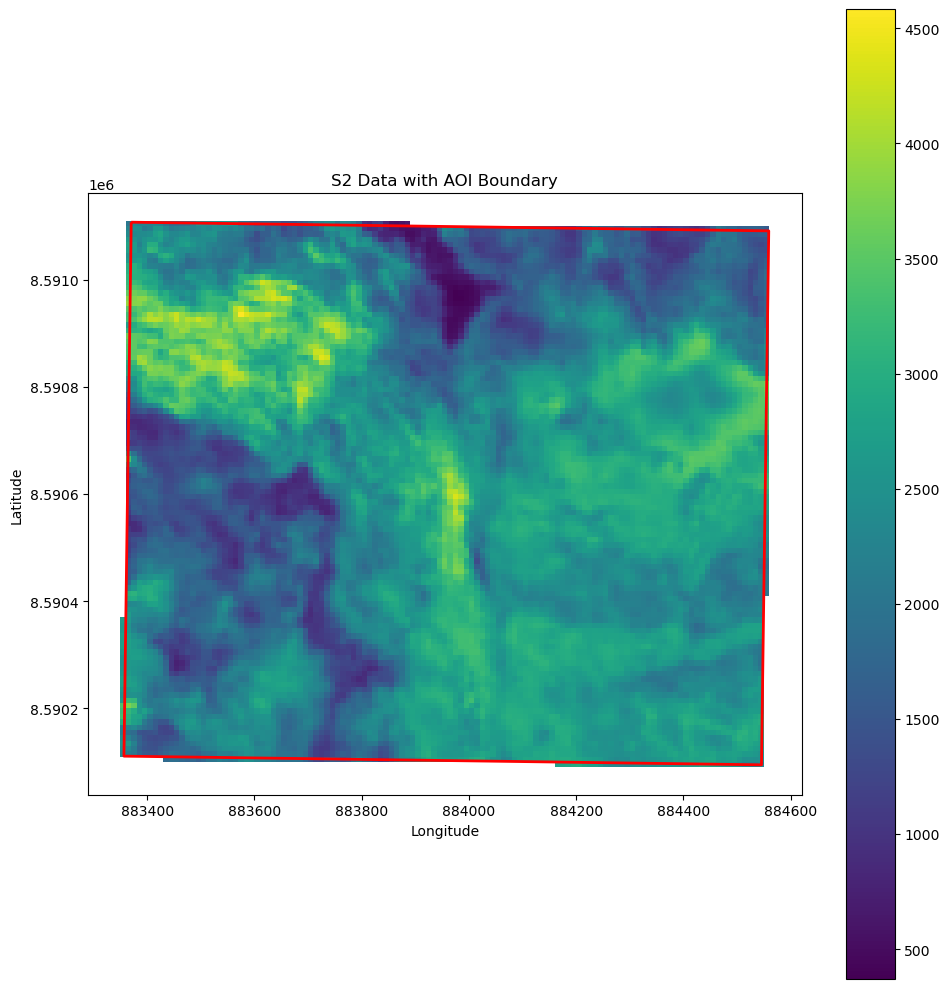

In [17]:
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt

s2_band_results = scene_results["B08.tif"]

# First create your base plot with the s2 data
fig, ax = plt.subplots(figsize=(10, 10))
s2_gdf = gpd.GeoDataFrame(s2_band_results, 
                         geometry=gpd.GeoSeries.from_wkt(s2_band_results['boundary_wkt']), 
                         crs=s2_band_results.iloc[0]['crs'])
s2_gdf.plot(column='value', cmap='viridis', legend=True, ax=ax)

# Now load and overlay the GeoJSON boundary
# Replace 'path_to_your_geojson.geojson' with your actual file path
aoi_gdf = gpd.read_file(geojson_path)

# If needed, reproject to match the CRS of your s2_gdf
if aoi_gdf.crs != s2_gdf.crs:
    aoi_gdf = aoi_gdf.to_crs(s2_gdf.crs)

# Plot the AOI boundary on top of the existing plot with a distinct style
aoi_gdf.boundary.plot(ax=ax, color='red', linewidth=2)

# Optional: Add a title and labels
plt.title('S2 Data with AOI Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.tight_layout()
plt.show()

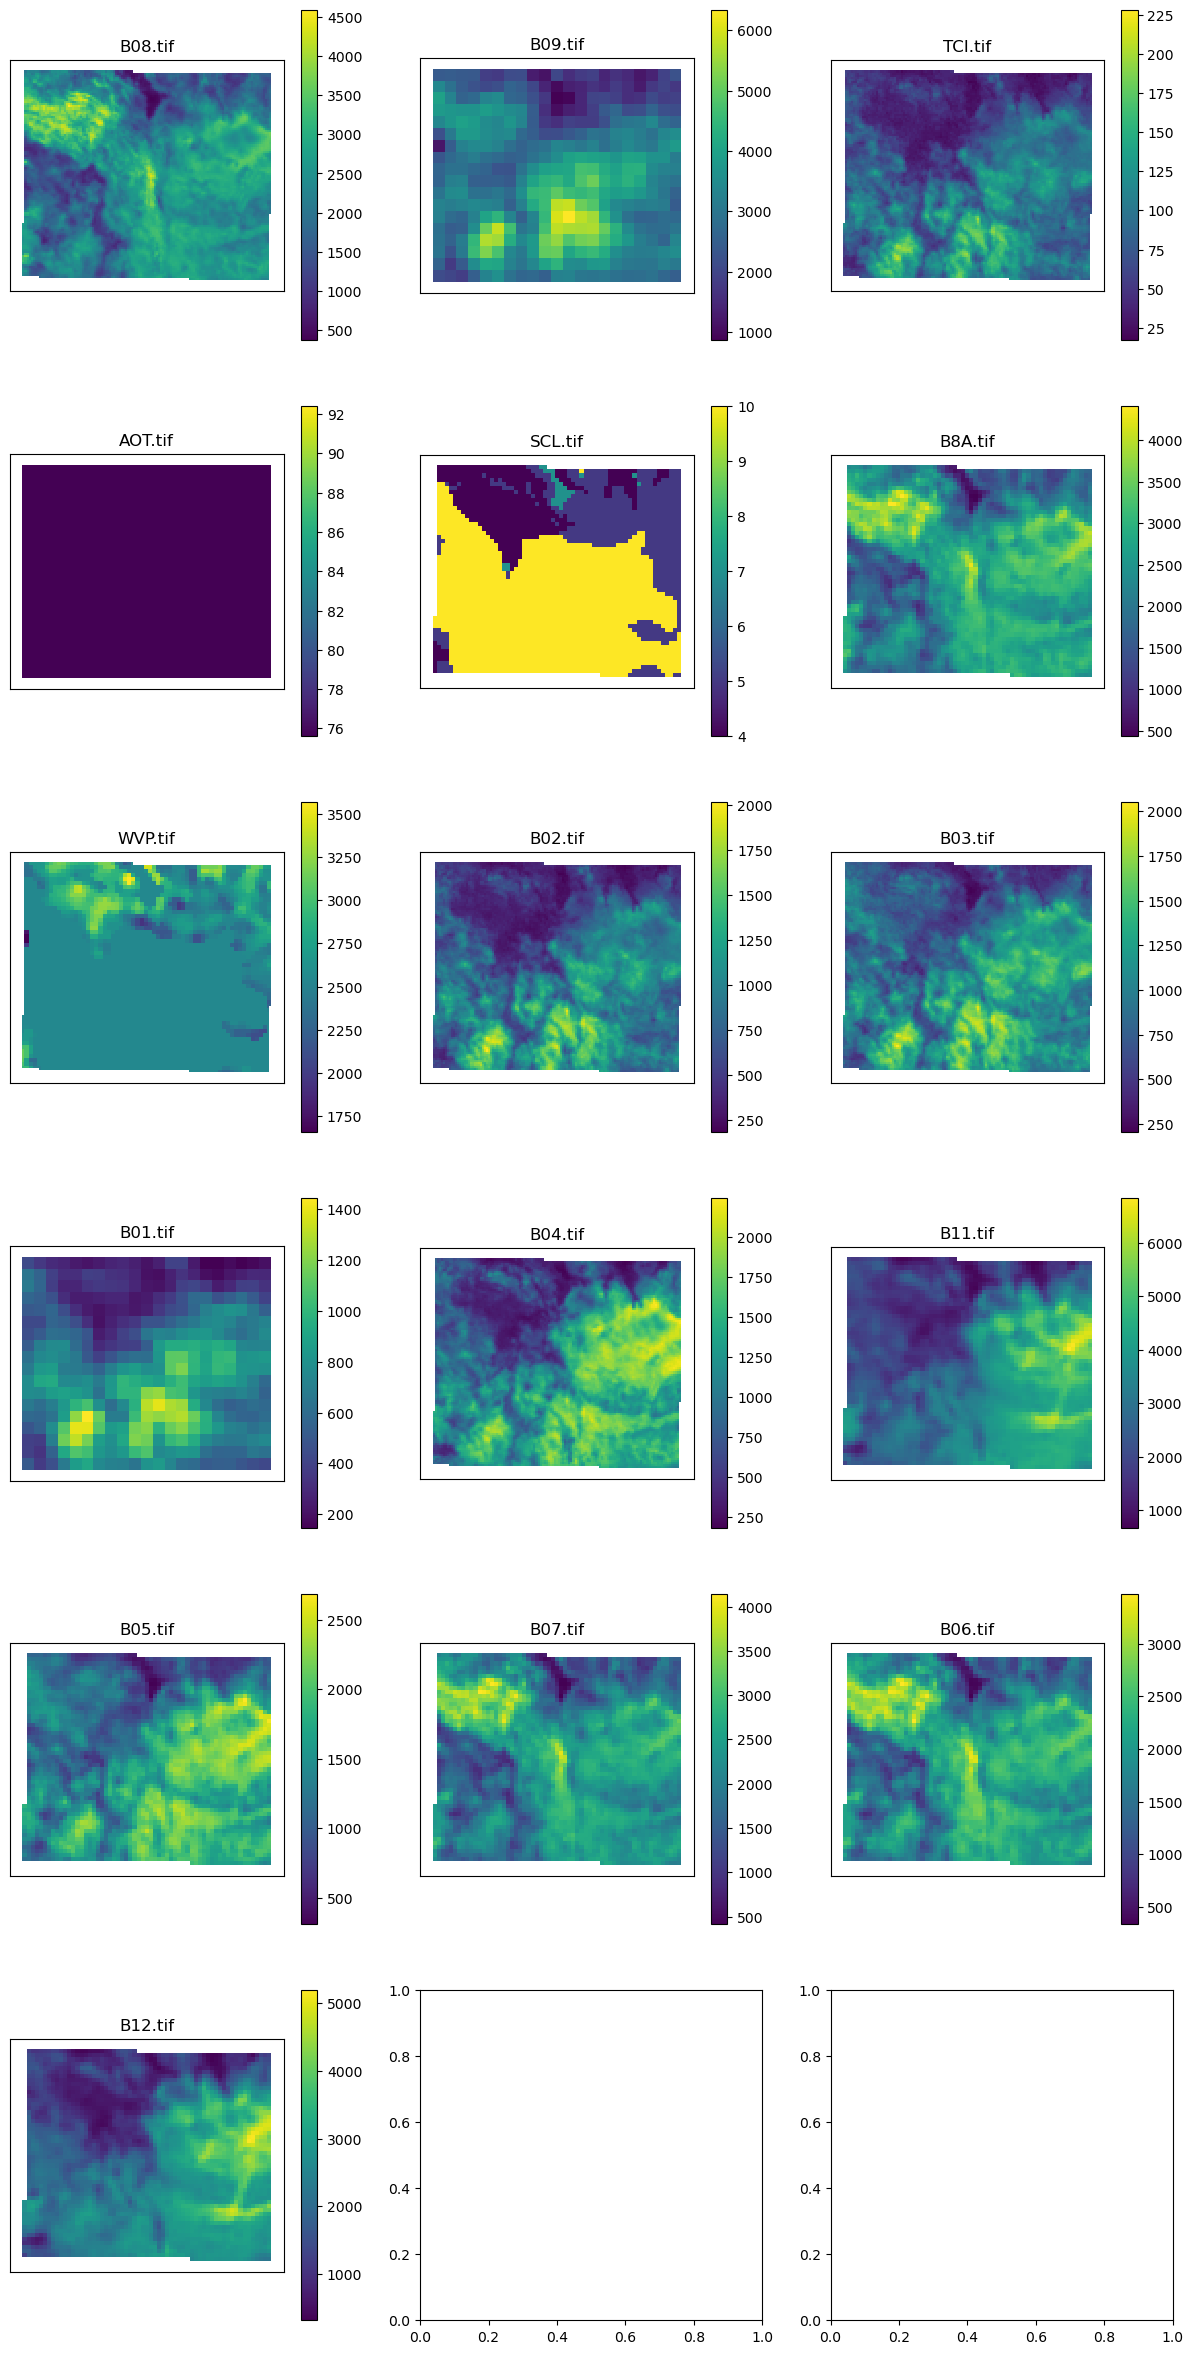

In [21]:
from math import ceil

num_bands = len(scene_results)
cols = 3
rows = ceil(num_bands / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axs.flatten()


for i, (band_name, band_results) in enumerate(scene_results.items()):
    ax = axes[i]

    band_gdf = gpd.GeoDataFrame(band_results,
                              geometry=gpd.GeoSeries.from_wkt(band_results['boundary_wkt']),
                              crs=band_results.iloc[0]['crs'])
    band_gdf.plot(column='value', cmap='viridis', legend=True, ax=ax)
    ax.set_title(band_name)
    
    # Turn off grid lines
    ax.set_xticks([])
    ax.set_yticks([])


